In [1]:
# dataExchange_thresholdOptimization.py
# -*- utf-8 -*-
# 用水事件阈值寻优模型
# 第一步：确定阈值的变化与划分得到的事件个数关系

import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt


inputfile = 'dataExchange_divideEvent.xlsx'
data = pd.read_excel(inputfile)
data.tail()

,发生时间,开关机状态,加热中,保温中,实际温度,热水量,水流量,加热剩余时间,当前设置温度,用水停顿时间间隔,事件编号
18742,2014-11-10 22:00:38,开,开,关,37°C,25%,26,17分钟,50°C,0.033333,170
18743,2014-11-10 22:00:42,开,开,关,37°C,25%,23,17分钟,50°C,0.066667,170
18744,2014-11-10 22:00:46,开,开,关,37°C,25%,25,17分钟,50°C,0.066667,170
18798,2014-11-10 22:19:43,开,关,开,50°C,50%,8,0分钟,50°C,18.950000,171
18800,2014-11-10 22:49:07,开,关,开,50°C,50%,8,0分钟,50°C,29.400000,172


In [2]:
data.drop([u'事件编号'],axis=1,inplace = True)
data.to_excel('thresholdOptimization.xlsx')

In [4]:
#确定阈值与事件数的关系
#****************************
#@1  目标：确定阈值的变化与划分得到的事件个数关系
#    方法：通过频率分布直方图
#****************************
timedeltalist = np.arange(2.25,8.25,0.25)
# 从2.25到8.25间，以间隔为0.25，确定阈值即，阈值范围为[2.25,2.5,2.75,3,...,7.75,8]
counts = [] # 记录不同阈值下的事件个数
for i in range(len(timedeltalist)):
    threshold = pd.Timedelta(minutes = timedeltalist[i])#阈值为四分钟
    d = data[u'发生时间'].diff() > threshold #  # 相邻时间做差分，比较是否大于阈值
    data[u'事件编号'] = d.cumsum() + 1 # 通过累积求和的方式为事件编号
    temp = data[u'事件编号'].max()
    counts.append(temp)
coun = pd.Series(counts, index=timedeltalist)
coun

2.25    197
2.50    194
2.75    191
3.00    186
3.25    181
3.50    178
3.75    174
4.00    172
4.25    172
4.50    171
4.75    171
5.00    171
5.25    169
5.50    164
5.75    164
6.00    163
6.25    161
6.50    159
6.75    158
7.00    158
7.25    158
7.50    155
7.75    154
8.00    153
dtype: int64

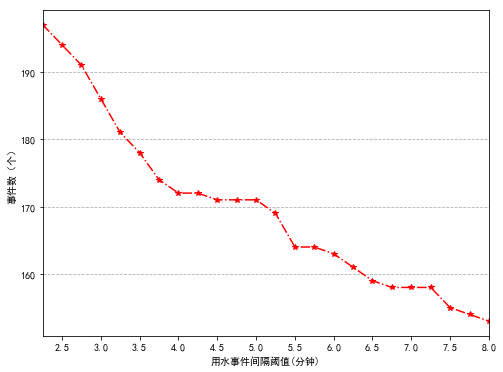

In [5]:
# 画频率分布直方图
#将阈值与对应的事件数绘制成频率分布直方图，以确定最优阈值

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']= False
plt.rc('figure', figsize=(8,6))
np.set_printoptions(precision=4)
fig = plt.figure()
fig.set(alpha=0.2)#设置图标透明度
ax = fig.add_subplot(1,1,1)
# coun.plot(linestyle='-.',color='r',marker='<')
coun.plot(style='-.r*')#同上
ax.locator_params('x',nbins = int(len(coun)/2)+1)  # (****)
ax.set_xlabel(u'用水事件间隔阈值(分钟)')
ax.set_ylabel(u'事件数（个）')
ax.grid(axis='y',linestyle='--') # (****)
plt.savefig('threshold_numofCase.jpg')
plt.show()


In [6]:
# 由上图可知，图像趋势平缓说明用户的停顿习惯趋于稳定，所以取该段时间开始作为阈值，既不会将短的用水时间合并，也不会将长的用水时间拆开
# 因此，最后选取一次用水时间间隔阈值为4分钟
# 利用阈值的斜率指标来作为某点的斜率指标
# 第二步：阈值优化
#****************************
#@2  目标：确定阈值的变化与划分得到的事件个数关系
#    方法：通过图像中斜率指标
#****************************

# 当存在阈值的斜率指标 k<KS :
#     取阈值最小的点A（可能存在多个阈值的斜率指标小于1）的横坐标x作为用水事件划分的阈值（该值是经过实验数据验证的专家阈值）
# 当不存在阈值的斜率指标 k<KS：
#     找所有阈值中“斜率指标最小”的阈值t1：
#     若：该阈值t1对应的斜率指标小于KS2：
#         则取该阈值作为用水事件划分的阈值
#     若：该阈值t1对应的斜率指标不小于KS2
#         则阈值取默认值——4分钟
# 备注：
# KS是评价斜率指标用的专家阈值1
# KS是评价斜率指标用的专家阈值2

data = pd.read_excel('thresholdOptimization.xlsx')
n = 4 #使用以后四个点的平均斜率
KS = 1 # 专家阈值1
KS2 = 5 # 专家阈值2

In [7]:
def event_num(ts):
    d = data[u'发生时间'].diff() > ts # 相邻时间做差分，比较是否大于阈值（*****）
    return d.sum()+1 # 直接返回事件数（*****）

dt = [pd.Timedelta(minutes = i) for i in np.arange(1,9,0.25)]#（***）
h = DataFrame(dt,columns = [u'阈值']) # 定义阈值列（**）
h[u'事件数'] = h[u'阈值'].apply(event_num) # 计算每个阈值对应的事件数（*****）
h[u'斜率'] = h[u'事件数'].diff()/0.25 # 计算每个相邻点对应的斜率（****）
h[u'斜率指标偏移前'] = pd.rolling_mean(h[u'斜率'].abs(), n)# 采用当前指标和后n个指标斜率的绝对值的平均作为当前指标的斜率

h[u'斜率指标'] = np.nan
h[u'斜率指标'][:-4] = h[u'斜率指标偏移前'] [4:]

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  if __name__ == '__main__':
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [8]:
mink = h[u'斜率指标'][h[u'斜率指标'] < KS]# 斜率指标小于1的值的集合
mink1 = h[u'斜率指标'][h[u'斜率指标'] < KS2]# 斜率指标小于5的值的集合

if list(mink): # 斜率指标值小于1不为空时，即，存在斜率指标值小于1时
    minky = [h[u'阈值'][i] for i in mink.index]# 取“阈值最小”的点A所对应的间隔时间作为ts
    ts = min(minky) #取最小时间为ts
elif list(mink1):# 当不存在斜率指标值小于1时,找所有阈值中“斜率指标最小”的阈值
    t1 = h[u'阈值'][h[u'斜率指标'].idxmin()] #“斜率指标最小”的阈值t1
    # ts = h[u'阈值'][h[u'斜率指标偏移前'].idxmin() - n] #等价于前一行作用（*****）
    # 备注：用idxmin返回最小值的Index，由于rolling_mean自动计算的是前n个斜率的绝对值的平均，所以结果要平移-n，得到偏移后的各个值的斜率指标，注意：最后四个值没有斜率指标因为找不出在它以后的四个更长的值
    if h[u'斜率指标'].min()<5:
        ts = t1#当该阈值的斜率指标小于5，则取该阈值作为用水事件划分的阈值
    else:
        ts = pd.Timedelta(minutes = 4)# 当该阈值的斜率指标不小于5，则阈值取默认值——4分钟

tm = ts/np.timedelta64(1, 'm')

print "当前时间最优时间间隔为%s分钟" % tm

当前时间最优时间间隔为4.0分钟


In [9]:
coun[4.00] # 可知，当最优时间是4分钟时，事件数是172个

172